In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from functools import partial
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

#DIR = '/PATH/TO/YOUR/DATA'
DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
bureau = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/bureau_balance.csv'))

In [2]:
bureau_balance.shape

(27299925, 3)

In [3]:
bureau_balance = bureau_balance.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='right')
bureau_balance.shape

(25121815, 4)

In [4]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR
0,5715448,0.0,C,380361
1,5715448,-1.0,C,380361
2,5715448,-2.0,C,380361
3,5715448,-3.0,C,380361
4,5715448,-4.0,C,380361


## Solution 5
### Hand crafted features

In [5]:
def _status_to_int(status):
    if status in ['X', 'C']:
        return 0
    if pd.isnull(status):
        return np.nan
    return int(status)

In [6]:
bureau_balance['bureau_balance_dpd_level'] = bureau_balance['STATUS'].apply(_status_to_int)
bureau_balance['bureau_balance_status_unknown'] = (bureau_balance['STATUS'] == 'X').astype(int)

In [7]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,bureau_balance_dpd_level,bureau_balance_status_unknown
0,5715448,0.0,C,380361,0.0,0
1,5715448,-1.0,C,380361,0.0,0
2,5715448,-2.0,C,380361,0.0,0
3,5715448,-3.0,C,380361,0.0,0
4,5715448,-4.0,C,380361,0.0,0


In [8]:
groupby = bureau_balance.groupby(['SK_ID_CURR'])
features = pd.DataFrame({'SK_ID_CURR': bureau_balance['SK_ID_CURR'].unique()})

In [9]:
def last_k_installment_features(gr, periods):
    gr_ = gr.copy()

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_installment_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_[gr_['MONTHS_BALANCE'] >= (-1) * period]

        features = add_features_in_group(features, gr_period, 'bureau_balance_dpd_level',
                                             ['sum', 'mean', 'max', 'std', 'skew', 'kurt'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'bureau_balance_status_unknown',
                                             ['sum', 'mean'],
                                             period_name)
    return features

In [10]:
func = partial(last_k_installment_features, periods=[6, 12, 24, 60, 10e16])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 31/31.0 [07:14<00:00, 14.01s/it]


### Trend features

In [11]:
def trend_in_last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        gr_period = gr_[gr_['MONTHS_BALANCE'] >= (-1) * period]

        features = add_trend_feature(features, gr_period,
                                         'bureau_balance_dpd_level', '{}_period_trend_'.format(period)
                                         )
    return features

def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

In [12]:
func = partial(trend_in_last_k_installment_features, periods=[6,12,24,60])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 31/31.0 [04:43<00:00,  9.14s/it]


In [13]:
features.head()

,SK_ID_CURR,all_installment_bureau_balance_dpd_level_kurt,all_installment_bureau_balance_dpd_level_max,all_installment_bureau_balance_dpd_level_mean,all_installment_bureau_balance_dpd_level_skew,all_installment_bureau_balance_dpd_level_std,all_installment_bureau_balance_dpd_level_sum,all_installment_bureau_balance_status_unknown_mean,all_installment_bureau_balance_status_unknown_sum,last_12_bureau_balance_dpd_level_kurt,...,last_6_bureau_balance_dpd_level_mean,last_6_bureau_balance_dpd_level_skew,last_6_bureau_balance_dpd_level_std,last_6_bureau_balance_dpd_level_sum,last_6_bureau_balance_status_unknown_mean,last_6_bureau_balance_status_unknown_sum,12_period_trend_bureau_balance_dpd_level,24_period_trend_bureau_balance_dpd_level,60_period_trend_bureau_balance_dpd_level,6_period_trend_bureau_balance_dpd_level
0,380361,-3.0,0.0,0.0,0.0,0.0,0.0,0.394472,157,-3.0,...,0.0,0.0,0.0,0.0,0.216867,18,0.0,0.0,0.0,0.0
1,401081,-3.0,0.0,0.0,0.0,0.0,0.0,0.093750,12,-3.0,...,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0
2,448798,-3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-3.0,...,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0
3,400434,-3.0,0.0,0.0,0.0,0.0,0.0,0.060606,2,-3.0,...,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0
4,393321,-3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-3.0,...,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0


In [14]:
def last_k_instalment_fractions(old_features, fraction_periods):
    features = old_features[['SK_ID_CURR']].copy()
    
    for short_period, long_period in fraction_periods:
        short_feature_names = _get_feature_names(old_features, short_period)
        long_feature_names = _get_feature_names(old_features, long_period)
        
        for short_feature, long_feature in zip(short_feature_names, long_feature_names):
            old_name_chunk = '_{}_'.format(short_period)
            new_name_chunk ='_{}by{}_fraction_'.format(short_period, long_period)
            fraction_feature_name = short_feature.replace(old_name_chunk, new_name_chunk)
            features[fraction_feature_name] = old_features[short_feature]/old_features[long_feature]
    return pd.DataFrame(features).fillna(0.0)

def _get_feature_names(features, period):
    return sorted([feat for feat in features.keys() if '_{}_'.format(period) in feat])

In [15]:
g = last_k_instalment_fractions(features, fraction_periods=[(6, 12), (6, 24), (12,24), (12, 60)])
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

,SK_ID_CURR,all_installment_bureau_balance_dpd_level_kurt,all_installment_bureau_balance_dpd_level_max,all_installment_bureau_balance_dpd_level_mean,all_installment_bureau_balance_dpd_level_skew,all_installment_bureau_balance_dpd_level_std,all_installment_bureau_balance_dpd_level_sum,all_installment_bureau_balance_status_unknown_mean,all_installment_bureau_balance_status_unknown_sum,last_12_bureau_balance_dpd_level_kurt,...,last_12by24_fraction_bureau_balance_status_unknown_mean,last_12by24_fraction_bureau_balance_status_unknown_sum,last_12by60_fraction_bureau_balance_dpd_level_kurt,last_12by60_fraction_bureau_balance_dpd_level_max,last_12by60_fraction_bureau_balance_dpd_level_mean,last_12by60_fraction_bureau_balance_dpd_level_skew,last_12by60_fraction_bureau_balance_dpd_level_std,last_12by60_fraction_bureau_balance_dpd_level_sum,last_12by60_fraction_bureau_balance_status_unknown_mean,last_12by60_fraction_bureau_balance_status_unknown_sum
0,380361,-3.0,0.0,0.0,0.0,0.0,0.0,0.394472,157,-3.0,...,0.805586,0.459459,1.0,0.0,0.0,0.0,0.0,0.0,0.643664,0.259542
1,401081,-3.0,0.0,0.0,0.0,0.0,0.0,0.093750,12,-3.0,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,448798,-3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-3.0,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,400434,-3.0,0.0,0.0,0.0,0.0,0.0,0.060606,2,-3.0,...,1.555556,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.722222,1.000000
4,393321,-3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-3.0,...,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [16]:
X = application.merge(features, on='SK_ID_CURR',how='left')[features.columns.tolist() + ['TARGET']]
X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                     1.000000
last_60_bureau_balance_dpd_level_std                       0.046973
all_installment_bureau_balance_dpd_level_std               0.046556
last_24_bureau_balance_dpd_level_max                       0.044986
last_12_bureau_balance_dpd_level_max                       0.044799
last_6_bureau_balance_dpd_level_max                        0.044622
last_6_bureau_balance_dpd_level_skew                       0.044186
last_24_bureau_balance_dpd_level_std                       0.044148
last_12_bureau_balance_dpd_level_std                       0.041031
last_6_bureau_balance_dpd_level_std                        0.038619
last_60_bureau_balance_dpd_level_max                       0.038086
last_12by24_fraction_bureau_balance_dpd_level_max          0.038080
last_12by60_fraction_bureau_balance_dpd_level_max          0.038075
last_12_bureau_balance_dpd_level_skew                      0.037983
last_6by24_fraction_bureau_balance_dpd_level_max

In [17]:
regex = '_bureau_balance'
X_corr_truncated = X_corr.sort_values('TARGET', ascending=False).filter(regex=regex, axis=0)
X_corr_truncated['TARGET']

last_60_bureau_balance_dpd_level_std                       0.046973
all_installment_bureau_balance_dpd_level_std               0.046556
last_24_bureau_balance_dpd_level_max                       0.044986
last_12_bureau_balance_dpd_level_max                       0.044799
last_6_bureau_balance_dpd_level_max                        0.044622
last_6_bureau_balance_dpd_level_skew                       0.044186
last_24_bureau_balance_dpd_level_std                       0.044148
last_12_bureau_balance_dpd_level_std                       0.041031
last_6_bureau_balance_dpd_level_std                        0.038619
last_60_bureau_balance_dpd_level_max                       0.038086
last_12by24_fraction_bureau_balance_dpd_level_max          0.038080
last_12by60_fraction_bureau_balance_dpd_level_max          0.038075
last_12_bureau_balance_dpd_level_skew                      0.037983
last_6by24_fraction_bureau_balance_dpd_level_max           0.037835
last_6by12_fraction_bureau_balance_dpd_level_max

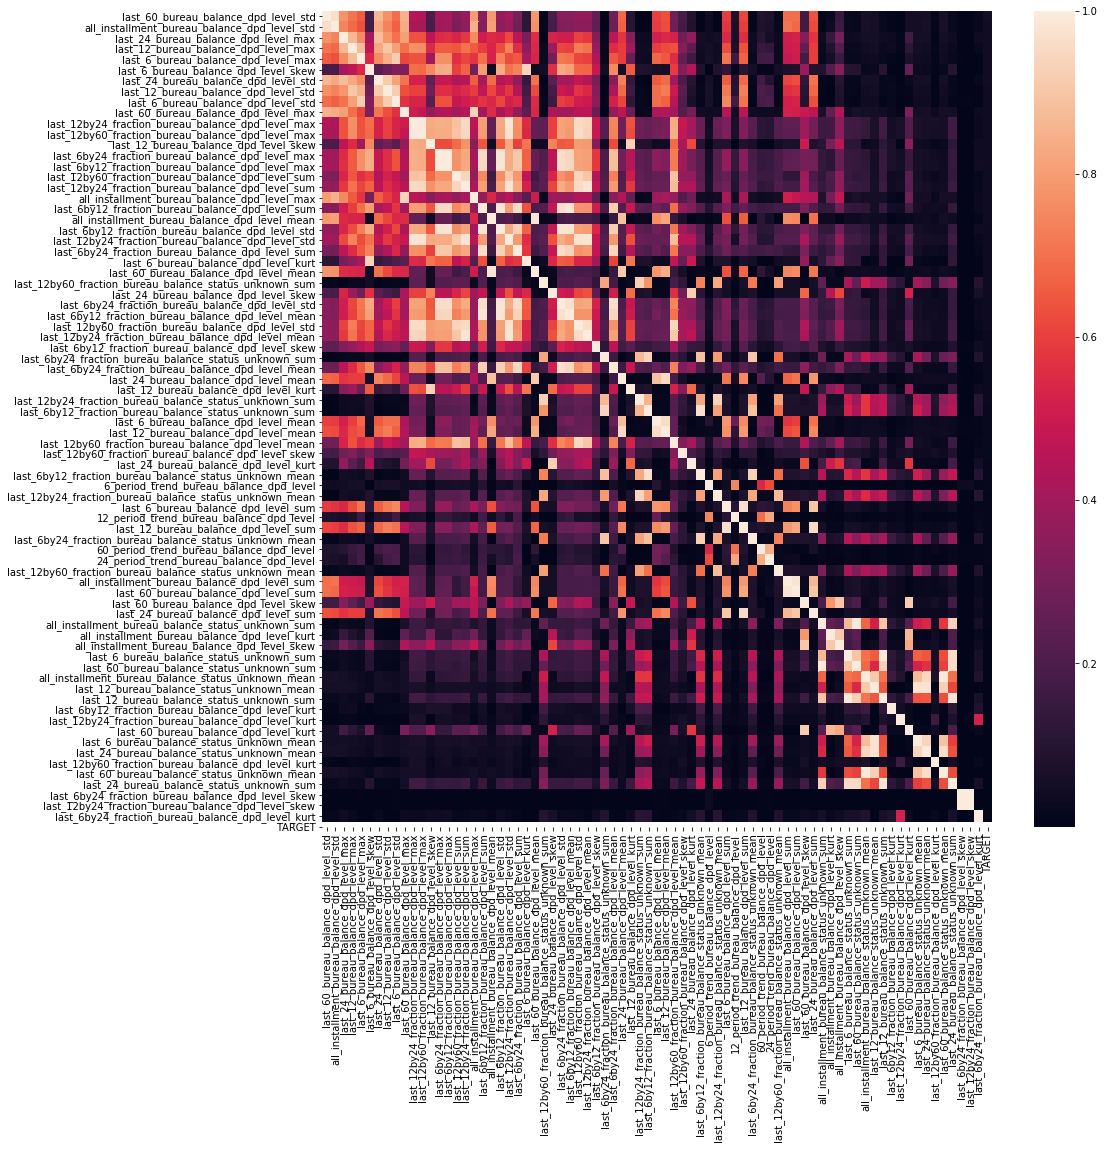

In [18]:
colnames = X_corr_truncated.index.tolist() + ['TARGET']
plt.figure(figsize=(15, 15));
sns.heatmap(X_corr_truncated[colnames], 
            xticklabels=colnames,
            yticklabels=colnames)

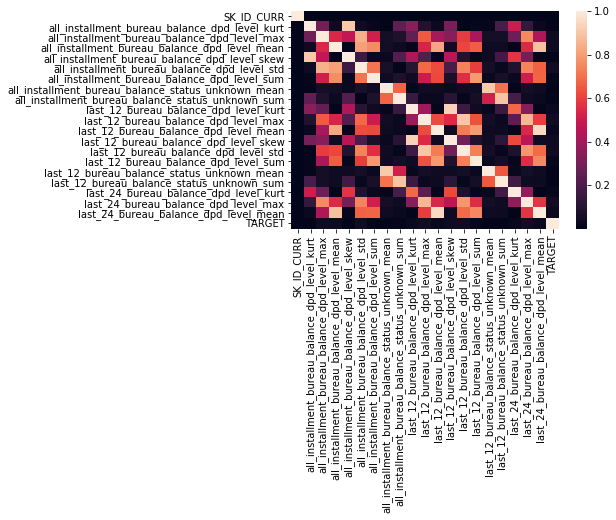

In [19]:
X_to_plot = X[X.columns[0:20].tolist()+['TARGET']]
X_corr_to_plot = abs(X_to_plot.corr())
X_corr_to_plot.sort_values('TARGET', ascending=False)['TARGET']
sns.heatmap(X_corr_to_plot, 
            xticklabels=X_corr_to_plot.columns,
            yticklabels=X_corr_to_plot.columns)

last_24_bureau_balance_dpd_level_skew


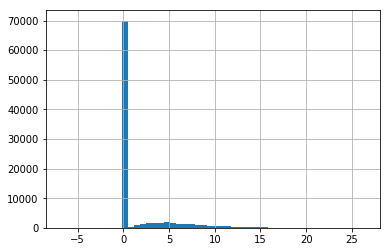

last_24_bureau_balance_dpd_level_std


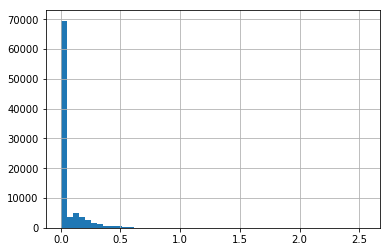

last_24_bureau_balance_dpd_level_sum


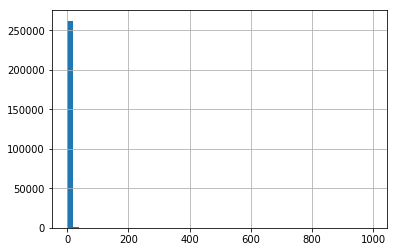

last_24_bureau_balance_status_unknown_mean


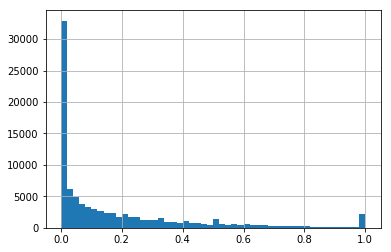

last_24_bureau_balance_status_unknown_sum


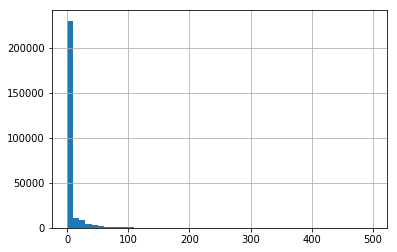

last_60_bureau_balance_dpd_level_kurt


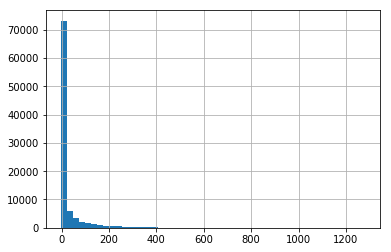

last_60_bureau_balance_dpd_level_max


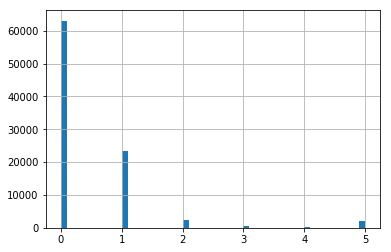

last_60_bureau_balance_dpd_level_mean


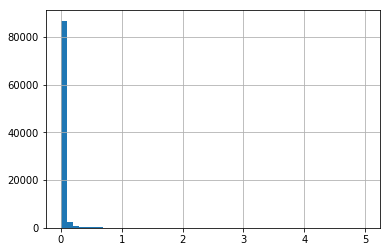

last_60_bureau_balance_dpd_level_skew


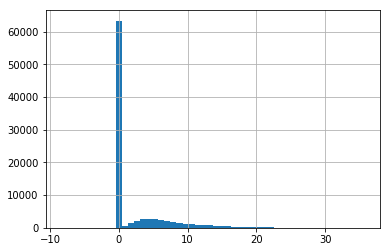

last_60_bureau_balance_dpd_level_std


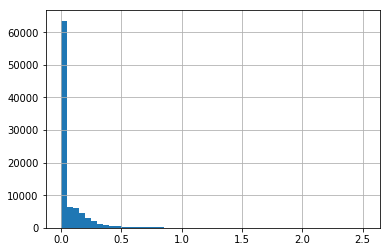

last_60_bureau_balance_dpd_level_sum


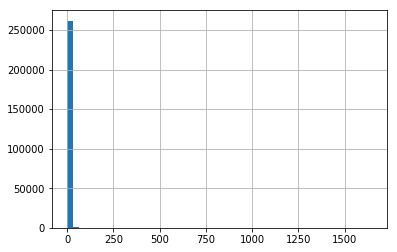

last_60_bureau_balance_status_unknown_mean


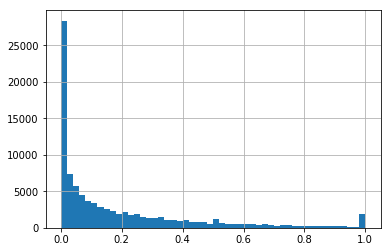

last_60_bureau_balance_status_unknown_sum


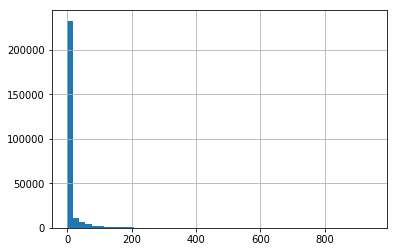

last_6_bureau_balance_dpd_level_kurt


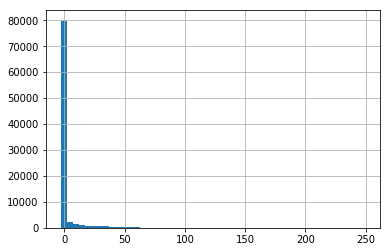

last_6_bureau_balance_dpd_level_max


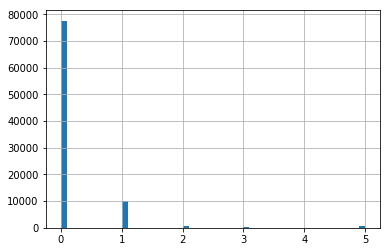

last_6_bureau_balance_dpd_level_mean


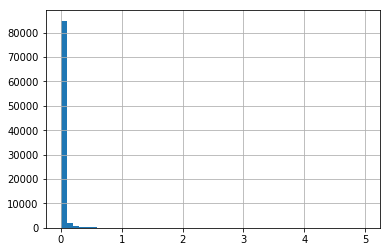

last_6_bureau_balance_dpd_level_skew


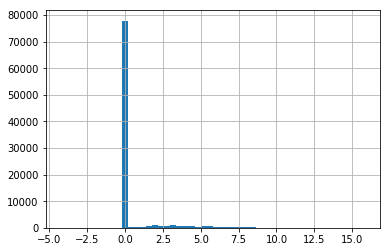

last_6_bureau_balance_dpd_level_std


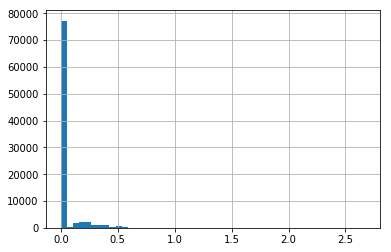

last_6_bureau_balance_dpd_level_sum


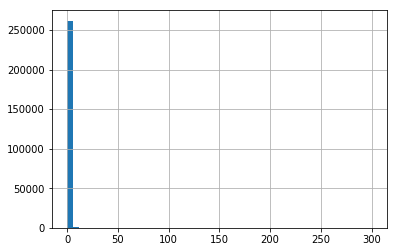

last_6_bureau_balance_status_unknown_mean


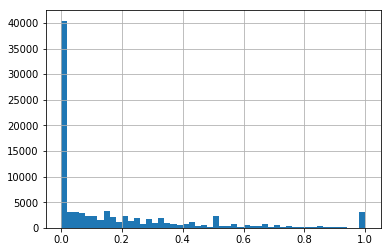

In [20]:
columns_to_use = X.columns[20:40]

for col in columns_to_use:
    print(col)
    X[col].hist(bins=50).plot()
    plt.show()